# Assigment 1
Made by Vladimir Klepikov

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from pandas_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from category_encoders import OneHotEncoder
from sklearn.svm import SVC




leets load some data

In [83]:
stream_train_df = pd.read_csv('.\\stream\\train_data.csv')
stream_test_df = pd.read_csv('.\\stream\\test_data.csv')
bitrate_train_df = pd.read_csv('.\\bitrate\\bitrate_train.csv')
bitrate_test_df = pd.read_csv('.\\bitrate\\bitrate_test.csv')

Now let's check what's in

In [6]:
stream_train_df.head(5)

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,off,partial,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,off,partial,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,off,partial,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,off,partial,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,off,partial,50.0,0


In [7]:
bitrate_train_df.head(5)

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
0,24.4,0.516398,91.1,6.723921,0.0,0.0,0.0,460.5,7.648529,616.0
1,28.6,2.065591,99.7,15.923777,0.0,0.0,0.0,616.3,155.414893,565.0
2,30.0,0.000000,98.1,11.798776,0.0,0.0,0.0,565.2,9.077445,573.0
3,30.3,0.948683,99.4,13.014522,0.0,0.0,0.0,573.8,28.350191,585.0
4,29.9,0.316228,123.2,62.476307,0.0,0.0,0.0,585.8,59.458295,555.0


In [8]:
bitrate_report=ProfileReport(bitrate_train_df)
#bitrate_report.to_file('bitrate_report.html')
stream_report=ProfileReport(stream_train_df)
#stream_report.to_file('stream_report.html')

## Regression

Here i try to predict bitrate on game session data. Short lookup of features we can see higher. Let's dive deeper and look at correlation matrix. It's implementation as function lower

In [19]:
def corrMatrix(df):
    cols = df.columns
    data = round(df.corr(),2) 
    
    fig, ax = plt.subplots()
    ax.imshow(data, cmap="gray")

    ax.set_xticks(np.arange(cols.shape[0]), labels=cols)
    ax.set_yticks(np.arange(cols.shape[0]), labels=cols)

    plt.setp(ax.get_xticklabels(), rotation=60,
             ha="right", rotation_mode="anchor")

    for i in range(cols.shape[0]):
        for j in range(cols.shape[0]):
            text = ax.text(j, i, data.iloc[i, j],
                           ha="center", va="center", color="red")

    # fig.tight_layout()
    plt.show()

    return data


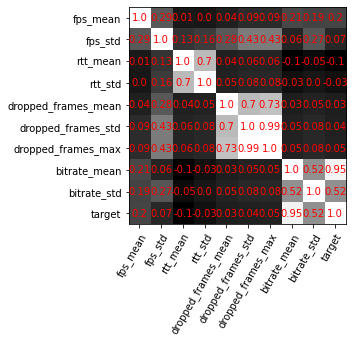

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
fps_mean,1.00,0.29,0.01,0.00,0.04,0.09,0.09,0.21,0.19,0.20
fps_std,0.29,1.00,0.13,0.16,0.28,0.43,0.43,0.06,0.27,0.07
rtt_mean,0.01,0.13,1.00,0.70,0.04,0.06,0.06,-0.10,-0.05,-0.10
rtt_std,0.00,0.16,0.70,1.00,0.05,0.08,0.08,-0.03,0.00,-0.03
dropped_frames_mean,0.04,0.28,0.04,0.05,1.00,0.70,0.73,0.03,0.05,0.03
dropped_frames_std,0.09,0.43,0.06,0.08,0.70,1.00,0.99,0.05,0.08,0.04
dropped_frames_max,0.09,0.43,0.06,0.08,0.73,0.99,1.00,0.05,0.08,0.05
bitrate_mean,0.21,0.06,-0.10,-0.03,0.03,0.05,0.05,1.00,0.52,0.95
bitrate_std,0.19,0.27,-0.05,0.00,0.05,0.08,0.08,0.52,1.00,0.52
target,0.20,0.07,-0.10,-0.03,0.03,0.04,0.05,0.95,0.52,1.00


In [20]:
corrMatrix(bitrate_train_df)

Now lets remove 0.5 persent of very high and low amounts to look remove some errors in data distribution

In [40]:
bitrate_train_df_chopped=bitrate_train_df.copy()
bitrate_train_df_chopped=bitrate_train_df_chopped.loc[bitrate_train_df["rtt_std"]             < bitrate_train_df["rtt_std"]            .quantile(.995)]
bitrate_train_df_chopped=bitrate_train_df_chopped.loc[bitrate_train_df["rtt_mean"]            < bitrate_train_df["rtt_mean"]           .quantile(.995)]
bitrate_train_df_chopped=bitrate_train_df_chopped.loc[bitrate_train_df["fps_mean"]            < bitrate_train_df["fps_mean"]           .quantile(.995)]
bitrate_train_df_chopped=bitrate_train_df_chopped.loc[bitrate_train_df["dropped_frames_mean"] < bitrate_train_df["dropped_frames_mean"].quantile(.995)]
bitrate_train_df_chopped=bitrate_train_df_chopped.loc[bitrate_train_df["dropped_frames_std"]  < bitrate_train_df["dropped_frames_std"] .quantile(.995)]
bitrate_train_df_chopped=bitrate_train_df_chopped.loc[bitrate_train_df["fps_std"]             < bitrate_train_df["fps_std"]            .quantile(.995)]

print("stock size",bitrate_train_df.shape)
print("new size", bitrate_train_df_chopped.shape)

stock size (379021, 10)
new size (370071, 10)


Now we can plot data and predict some more features by drawing features to target relations

In [49]:
def drawData(ds,labels, alpha):

    lines = ds.shape[1]//2+ds.shape[1]%2
    fig, ax = plt.subplots(lines, 2)
    fig.set_size_inches(10,5 * lines)

    for i in range(0, ds.shape[1]-1, 2):
        row = i//2
        ax[row, 0].scatter(ds.iloc[:,i], labels, alpha=alpha)
        ax[row, 0].axvline(np.mean(ds.iloc[:,i]), c = 'yellow')
        ax[row, 0].set_title(f'{ds.columns[i]} | target')

        ax[row, 1].scatter(ds.iloc[:,i+1], labels, alpha=alpha)
        ax[row, 1].axvline(np.mean(ds.iloc[:,i+1]), c = 'yellow')
        ax[row, 1].set_title(f'{ds.columns[i+1]} | target')

    plt.show()

    return None



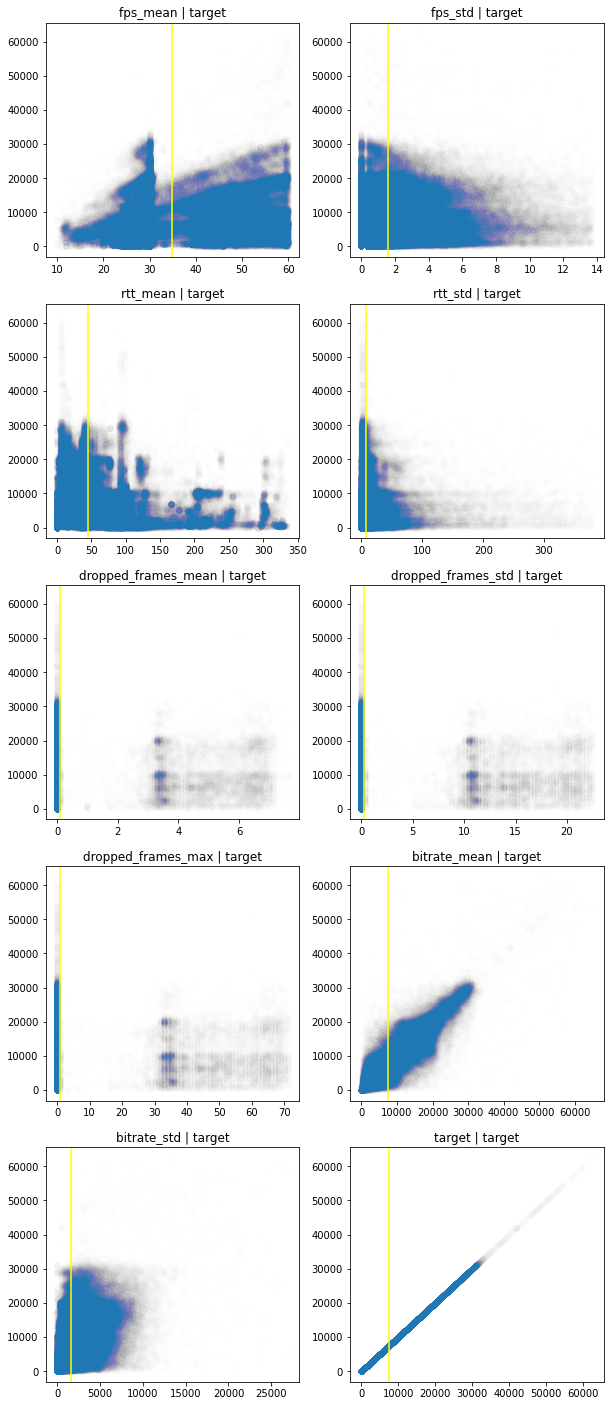

In [50]:
drawData(bitrate_train_df_chopped, bitrate_train_df_chopped["target"], alpha=0.005)

Yeah, target to target looks beauty... And bitrate to target(really why? just joke). So, we have other parameters that don't loooks good. And we can see some peaks on fps(hello to 30 fps limiter), peaks on rtt (hello to geography and people distribution). But we haven't got something better, so let's go to PCA analyze

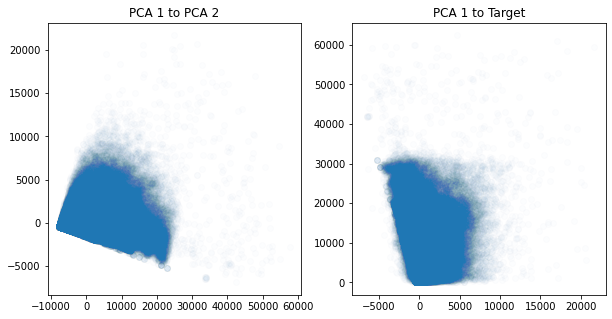

In [54]:
pca = PCA(2).fit(bitrate_train_df_chopped.drop(
    "target", axis=1), bitrate_train_df_chopped["target"])
x_train_pca = pca.transform(bitrate_train_df_chopped.drop("target", axis=1))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax[0].scatter(x_train_pca[:, 0], x_train_pca[:, 1], alpha=0.01)
ax[0].set_title("PCA 1 to PCA 2")
ax[1].scatter(x_train_pca[:, 1],
              bitrate_train_df_chopped["target"], alpha=0.01)
ax[1].set_title("PCA 1 to Target")
plt.show()


Looks same bad as higher variant. Okay... Let's go to

## Feature engineering

Here we convert all our data to something more pleasant for algoritms

In [103]:
x_train = bitrate_train_df_chopped.drop(["target","bitrate_std",'bitrate_mean'], axis=1)
y_train = bitrate_train_df_chopped["target"]

x_test = bitrate_test_df.drop(["target","bitrate_std",'bitrate_mean'], axis=1)
y_test = bitrate_test_df["target"]


In [109]:
scalertrain = MinMaxScaler()
x_train = scalertrain.fit_transform(x_train)
scalertrainX = MinMaxScaler()
x_test = scalertrain.transform(x_test)

In [110]:
lasso = Lasso(alpha=0.1).fit(x_train,y_train)
y_pred = lasso.predict(x_test)
print("MSE on testset w lasso:", mean_squared_error(y_test, y_pred))
print('MAE on testset w lasso:', mean_absolute_error(y_test, y_pred))
print('r2 score on testset w lasso:', r2_score(y_test, y_pred))

MSE on testset w lasso: 34302951.14379091
MAE on testset w lasso: 4505.4024134199
r2 score on testset w lasso: 0.03807340541921911


In [111]:
ridge = Ridge(alpha=0.1).fit(x_train,y_train)
y_pred = lasso.predict(x_test)
print("MSE on testset w  ridge:", mean_squared_error(y_test, y_pred))
print('MAE on testset w ridge:', mean_absolute_error(y_test, y_pred))
print('r2 score on testset w ridge:', r2_score(y_test, y_pred))

MSE on testset w  ridge: 34302951.14379091
MAE on testset w ridge: 4505.4024134199
r2 score on testset w ridge: 0.03807340541921911


lol there is no disserence between selection

poor data...  check polynomial features

In [112]:
pfeat = PolynomialFeatures().fit_transform(x_train, y_train)
pfeat_t = PolynomialFeatures().fit_transform(x_test, y_test)
pfeat_r = LinearRegression().fit(pfeat, y_train)
y_pred = pfeat_r.predict(pfeat_t)
y_pred_train = pfeat_r.predict(pfeat)
print("MSE on testset w polyfeatures:", mean_squared_error(y_test, y_pred))
print('MAE on testset w polyfeatures:', mean_absolute_error(y_test, y_pred))
print('r2 score on testset w polyfeatures:', r2_score(y_test, y_pred))

MSE on testset w polyfeatures: 34508338.113043256
MAE on testset w polyfeatures: 4527.068157481412
r2 score on testset w polyfeatures: 0.03231392463647198


huh r2 better... but it isn't solve this problem anymore

# Classification
Now we need predict stream quality in cloud game: good or bad classification
First look i have in begin of this notebook, now i should preprocess some data

In [82]:
stream_train_df.head()

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state_1,auto_bitrate_state_2,auto_bitrate_state_3,auto_fec_state,auto_fec_mean,stream_quality,auto_bitrate_state_lable
0,0.191975,0.001652,0.0,0.007063,0.000165,0.0,0.0,0.0,1.0,0.0,0.0,None,0.2,0.0,0.0
1,0.225020,0.006609,0.0,0.007730,0.000391,0.0,0.0,0.0,1.0,0.0,0.0,None,0.2,0.0,0.0
2,0.236035,0.000000,0.0,0.007606,0.000290,0.0,0.0,0.0,1.0,0.0,0.0,None,0.2,0.0,0.0
3,0.238395,0.003035,0.0,0.007706,0.000320,0.0,0.0,0.0,1.0,0.0,0.0,None,0.2,0.0,0.0
4,0.235248,0.001012,0.0,0.009552,0.001534,0.0,0.0,0.0,1.0,0.0,0.0,None,0.2,0.0,0.0


In [84]:
target_encoding = {'partial':1, 'off':0}
stream_train_df['auto_fec_state'] = stream_train_df['auto_fec_state'].apply(lambda x : target_encoding.get(x))
target_encoding = {'off':0., 'partial':0.5, 'full':1.}

stream_train_df['auto_bitrate_state_lable'] = stream_train_df['auto_bitrate_state'].apply(lambda x : target_encoding.get(x))

encoder = OneHotEncoder(cols=['auto_bitrate_state'], handle_unknown='error')
encoder.fit(stream_train_df)
stream_train_df = encoder.transform(stream_train_df)
scaler = MinMaxScaler()
scaler.fit(stream_train_df)
stream_train_df = pd.DataFrame(scaler.transform(stream_train_df), columns=stream_train_df.columns)

In [85]:
target_encoding = {'partial':1, 'off':0}
stream_test_df['auto_fec_state'] = stream_test_df['auto_fec_state'].apply(lambda x : target_encoding.get(x))
target_encoding = {'off':0., 'partial':0.5, 'full':1.}
stream_test_df['auto_bitrate_state_lable'] = stream_test_df['auto_bitrate_state'].apply(lambda x : target_encoding.get(x))

stream_test_df = encoder.transform(stream_test_df)

stream_test_df = pd.DataFrame(scaler.transform(stream_test_df), columns=stream_test_df.columns)

In [86]:
x_train = stream_train_df.drop(['stream_quality'], axis=1)
y_train = stream_train_df['stream_quality']
x_test = stream_test_df.drop(['stream_quality'], axis=1)
y_test = stream_test_df['stream_quality']


In [87]:
ridge = Ridge().fit(x_train, y_train)

In [88]:
coefs = np.array(ridge.coef_)
num_of_features = 8
indexes = sorted(range(len(coefs)), key=lambda k: -coefs[k])[:num_of_features]
selected_features = [x_train.columns.to_list()[i] for i in indexes]
print(selected_features)

['fps_std', 'rtt_std', 'fps_lags', 'rtt_mean', 'auto_fec_state', 'auto_bitrate_state_3', 'auto_bitrate_state_lable', 'auto_fec_mean']


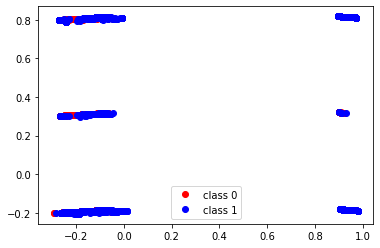

In [89]:
dim_reducer = PCA(n_components=2)
x_train_2d = dim_reducer.fit_transform(x_train[selected_features])

index = np.where(y_train == 0)[0]
plt.plot(x_train_2d[index][:,1], x_train_2d[index][:,0], 'ro', label="class 0")
index = np.where(y_train == 1)[0]
plt.plot(x_train_2d[index][:,1], x_train_2d[index][:,0], 'bo', label="class 1")

plt.legend()
plt.show()

In [91]:
classificators = [LogisticRegression(C=1, penalty='l1', solver='liblinear'), LogisticRegression('l2'), SVC(gamma='auto')]
for clf in classificators:
    clf.fit(x_train, y_train)

predictions = [clf.predict(x_test) for clf in classificators]

results = {'Model':['LogReg l1', 'LogReg l2', 'SVC']}

results['Accuracy'] = [accuracy_score(y_test, y_pred) for y_pred in predictions]
results['Presicion'] = [precision_score(y_test, y_pred) for y_pred in predictions]
results['Recall'] = [recall_score(y_test, y_pred) for y_pred in predictions]
results['Mean Absolute Error'] = [mean_absolute_error(y_test, y_pred) for y_pred in predictions]
results['Mean Squared Error'] = [mean_squared_error(y_test, y_pred) for y_pred in predictions]
results['Root Mean Squared Error'] = [np.sqrt(mean_squared_error(y_test, y_pred)) for y_pred in predictions]
results['Root Squared'] = [np.sqrt(r2_score(y_test, y_pred)) for y_pred in predictions]

measures = pd.DataFrame(data=results)

c:\Users\TheAR\.conda\envs\innolearn\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\TheAR\AppData\Local\Temp\ipykernel_14688\1635560129.py:15: RuntimeWarning: invalid value encountered in sqrt
  results['Root Squared'] = [np.sqrt(r2_score(y_test, y_pred)) for y_pred in predictions]


In [92]:

predictions_train = [clf.predict(x_train) for clf in classificators]

results_train = {'Model':['LogReg l1', 'LogReg l2', 'SVC']}

results_train['Accuracy'] = [accuracy_score(y_train, y_pred) for y_pred in predictions_train]
results_train['Presicion'] = [precision_score(y_train, y_pred) for y_pred in predictions_train]
results_train['Recall'] = [recall_score(y_train, y_pred) for y_pred in predictions_train]
results_train['Mean Absolute Error'] = [mean_absolute_error(y_train, y_pred) for y_pred in predictions_train]
results_train['Mean Squared Error'] = [mean_squared_error(y_train, y_pred) for y_pred in predictions_train]
results_train['Root Mean Squared Error'] = [np.sqrt(mean_squared_error(y_train, y_pred)) for y_pred in predictions_train]
results_train['Root Squared'] = [np.sqrt(r2_score(y_train, y_pred)) for y_pred in predictions_train]

measures_train = pd.DataFrame(data=results_train)

In [93]:
measures

,Model,Accuracy,Presicion,Recall,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,Root Squared
0,LogReg l1,0.940533,0.708708,0.130687,0.059467,0.059467,0.243859,0.115800
1,LogReg l2,0.940808,0.726788,0.130177,0.059192,0.059192,0.243295,0.134063
2,SVC,0.938287,0.979681,0.043010,0.061713,0.061713,0.248421,NaN
